## Load the dataset

In [1]:
import numpy as np
import pandas as pd

import missingno
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

import scipy as sp
from scipy.stats import skew

import warnings
warnings.filterwarnings("ignore")

In [8]:
df = pd.read_csv("train.csv")

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [10]:
len(df)

1460

In [11]:
df[df.duplicated()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


In [12]:
print(100 * (df.isna().sum()[df.isna().sum() > 0] / len(df)))

LotFrontage     17.739726
Alley           93.767123
MasVnrType       0.547945
MasVnrArea       0.547945
BsmtQual         2.534247
BsmtCond         2.534247
BsmtExposure     2.602740
BsmtFinType1     2.534247
BsmtFinType2     2.602740
Electrical       0.068493
FireplaceQu     47.260274
GarageType       5.547945
GarageYrBlt      5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
PoolQC          99.520548
Fence           80.753425
MiscFeature     96.301370
dtype: float64


In [13]:
# Load the test dataset
test_df = pd.read_csv("test.csv")
test_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [16]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

In [15]:
test_df[test_df.duplicated()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition


In [17]:
test_missing = test_df.isna().sum()

test_missing = 100 * (test_missing[test_missing > 0] / len(test_df))
test_missing

MSZoning         0.274160
LotFrontage     15.558602
Alley           92.666210
Utilities        0.137080
Exterior1st      0.068540
Exterior2nd      0.068540
MasVnrType       1.096642
MasVnrArea       1.028101
BsmtQual         3.015764
BsmtCond         3.084304
BsmtExposure     3.015764
BsmtFinType1     2.878684
BsmtFinSF1       0.068540
BsmtFinType2     2.878684
BsmtFinSF2       0.068540
BsmtUnfSF        0.068540
TotalBsmtSF      0.068540
BsmtFullBath     0.137080
BsmtHalfBath     0.137080
KitchenQual      0.068540
Functional       0.137080
FireplaceQu     50.034270
GarageType       5.209047
GarageYrBlt      5.346127
GarageFinish     5.346127
GarageCars       0.068540
GarageArea       0.068540
GarageQual       5.346127
GarageCond       5.346127
PoolQC          99.794380
Fence           80.123372
MiscFeature     96.504455
SaleType         0.068540
dtype: float64

### Check target column first

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

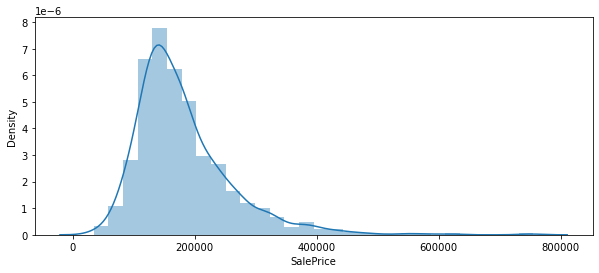

In [18]:
fig, ax = plt.subplots(figsize=(10,4))
sns.distplot(train_df['SalePrice'], bins=30, kde=True, ax=ax)

In [ ]:
# One way of doing it
fig, ax = plt.subplots(figsize=(10,4))
sns.distplot(np.log1p(train_df['SalePrice']), bins=30, kde=True, ax=ax);
# Perform log transformation 
train_df['SalePrice'] = np.log1p(train_df['SalePrice'])

In [ ]:
train_df['SalePrice'].isna().sum()

First of all I will concatenate these 2 dataframe for feature engineering. It will help me to avoid a problem where train and test dataset discrete features are different from each other.

In [ ]:
# Concatenate train/test datasets
df = pd.concat([train_df, test_df], axis=0)

## Numerical Features

In [ ]:
# Change these features into object type
change_type = ['MSSubClass','OverallQual','OverallCond','YearBuilt','YearRemodAdd','GarageYrBlt','MoSold','YrSold']

for col in change_type:
    df[col] = df[col].astype("object")

In [ ]:
# Describe numeric columns
df.drop("Id", axis=1).describe(include=['number']).T

In [ ]:
num_feat = [x for x in df.columns if df[x].dtype !="object"]

num_feat.remove("Id")

In [ ]:
# Correlation between numerical variables
corr_matrix = df[num_feat].corr()
plt.figure(figsize=(16,12))
sns.heatmap(corr_matrix.T, annot=True, cbar=False, cmap='coolwarm');

In [ ]:
# Correlated variables greater than 0.8
corr_matrix = df[num_feat].corr()
plt.figure(figsize=(12,12))
sns.heatmap(corr_matrix.T, annot=True, mask= corr_matrix < 0.8 ,cbar=False, cmap='coolwarm');

Let's check how these correlated variables to each other are correlated to the target column, so I can decide which of them remove from further analysis.

In [ ]:
price_corr_ser = df[num_feat].corr()['SalePrice']
price_corr_ser = price_corr_ser.sort_values(ascending=False)
price_corr_ser = price_corr_ser.drop("SalePrice")

fig, ax = plt.subplots(figsize=(10,12))
sns.barplot(x=price_corr_ser.values, y=price_corr_ser.index, palette="rocket_r")
plt.title("Numeric Feature Correlation with Traget Column");

In [ ]:
# Remove one of the highly correlated variables
high_correlated_var = ["GarageArea",'1stFlrSF','TotRmsAbvGrd']
df = df.drop(high_correlated_var, axis=1)

# Remove it from list of numeric columns
for c in high_correlated_var:
    num_feat.remove(c)

### Distribution of numeric features

In [ ]:
# Plot distribution of numeric variables
fig = plt.figure(figsize=(20,20))

for i in range(len(num_feat)):
    plt.subplot(14,5, i+1)
    sns.distplot(df[num_feat[i]], rug=True, hist=False, kde_kws={'bw':0.1})
    plt.title(num_feat[i])
    plt.xlabel("Value")
    plt.ylabel("Count")
    plt.tight_layout()
fig.show()

In [ ]:
# Visualize relation between numeric features and target column
fig = plt.figure(figsize=(20,20))
# numeric_df = num_df.drop('SalePrice', axis=1)

for i, col in enumerate(df[num_feat].columns):
    plt.subplot(12,5, i+1)
    sns.scatterplot(x=df[col], y=df['SalePrice'])
    plt.tight_layout()
    
fig.show()

### Numerical outliers

In [ ]:
fig = plt.figure(figsize=(24,15))

plt.subplot(4,3,1)
sns.distplot(df["LotArea"])

plt.subplot(4,3,2)
sns.scatterplot(x="LotArea", y="SalePrice", data=df)

In [ ]:
df["LotArea"].describe()

I will remove outliers from this continues numeric column later on as it would effect my test dataset for submission if I do it now.

**PoolArea**

In [ ]:
# Create binary column 1 if the house has a pool, 0 if not
df['isPool'] = df['PoolArea'].apply(lambda x: 0 if x == 0 else 1)
df['isPool'] = df['isPool'].astype("object")
df = df.drop('PoolArea',axis=1)
num_feat.remove("PoolArea")

**totalPorch**

In [ ]:
# create a new column where I concatenate all Porch columns
porch_col = ['OpenPorchSF','EnclosedPorch', '3SsnPorch', 'ScreenPorch']

df['totalPorch'] = np.zeros(len(df)).reshape(len(df),1)

for col in porch_col:
    df['totalPorch'] += df[col]
    
# Remove porch col from dataset
for c in porch_col:
    df.drop(c, axis=1, inplace=True)

# Remove it from the list of numerical columns
to_remove = ["OpenPorchSF", "EnclosedPorch", "3SsnPorch", "ScreenPorch"]
for c in to_remove:
    num_feat.remove(c)

# Add column to the list of numeric
num_feat.append("totalPorch")

**Bathroom columns**

In [ ]:
# Create new columns and drop relevant ones
df["TotBathAbvGrade"] = df["FullBath"] + (0.5 * df["HalfBath"])
df["TotBsmtBath"] = df["BsmtFullBath"] + (0.5 * df["BsmtHalfBath"])

# Remove columns
to_remove = ["FullBath","HalfBath","BsmtFullBath", "BsmtHalfBath"]

for col in to_remove:
    df.drop(col, axis=1, inplace=True)
    num_feat.remove(col)

# Append new ones to the numeric columns
num_feat.append("TotBathAbvGrade")
num_feat.append("TotBsmtBath")

Columns LotFrontage(Linear feet of street connected to property) and LotArea(Lot size in square feet) are highly correlated, so I will drop feature with missing values.

In [ ]:
# Remove useless numerical column
df.drop("LotFrontage", axis=1, inplace=True)
num_feat.remove("LotFrontage")

In [ ]:
# Create a plot again
fig = plt.figure(figsize=(15,15))

for i, col in enumerate(num_feat):
    plt.subplot(12,5, i+1)
    sns.scatterplot(x=df[col], y='SalePrice', data=df)
    plt.tight_layout()

fig.show()

### Missing values in numeric features

The only numerical column left with some missing values (less than 1%) so I will fill them with a mean of the column. I don't need to fill missing values in SalePrice Columns.

In [ ]:
# Show missing values
missingno.matrix(df[num_feat], figsize=(20,4))

In [ ]:
# Remove SalePrice temporary
num_feat.remove("SalePrice")

In [ ]:
from sklearn.impute import SimpleImputer

imp = SimpleImputer(missing_values=np.nan, strategy='median')
imp.fit(df[num_feat])
df[num_feat] = imp.transform(df[num_feat])

In [ ]:
for col in df[num_feat]:
    df[col] = df[col].apply(lambda x: np.log1p(x))
    
# Append SalePrice back to numeric columns
num_feat.append("SalePrice")

## Categorical features

#### Missing Values in Categorical

In [ ]:
# List of categorical columns
cat_feat = [x for x in df.columns if df[x].dtype == "object"]

# Create a multi plot with categorical features
fig = plt.figure(figsize=(18, 30))

for i , col in enumerate(cat_feat):
    plt.subplot(12,5, i+1)
    sns.boxplot(x=col, y='SalePrice', data=df)
    plt.ylabel("Log() SalePrice")
    plt.tight_layout()
    
fig.show()

There are some features that are useless(to many variables or the same information). First, I will try to create new features from them.

In [ ]:
cat_missing = df[cat_feat].isna().sum()

cat_missing = 100 * (cat_missing[cat_missing > 0] / len(df[cat_feat]))

plt.figure(figsize=(10,5))
sns.barplot(x= cat_missing.sort_values(ascending=False).values, y= cat_missing.sort_values(ascending=False).index)
plt.title("Missing Categorical Values in %");

#### Missing data in categorical columns

There are many methods to impute data, some of them are very sophisticated, but there is one flaw, we impute artificially created values. In case of categorical variables imputing mode of a column could be one of them, but I will fill missing values with a string "None" so I could retain the orginal information.

In [ ]:
# Fill missing values in categorical columns with a string
for col in cat_feat:
    if df[col].isna().sum() > 0:
        df[col] = df[col].fillna(value="NA")
    else:
        continue

In [ ]:
missingno.matrix(df[cat_feat], figsize=(20,4))

In [ ]:
# for col in cat_missing.columns:
    # print(f" Column '{col}' has unique values {df[col].unique()}")

In [ ]:
cat_missing = df[cat_feat].isna().sum()

cat_missing = 100 * (cat_missing[cat_missing > 0] / len(df[cat_feat]))

cat_missing

### Feature engineering for categorical variables

**GarageYrBlt column**

In [ ]:
# Creating new series 
is_garage = df['GarageYrBlt'].apply(lambda x: 1 if x != "NA" else 0)

# Plot new series
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

sns.countplot(is_garage, ax=axes[0])
sns.boxplot(x=is_garage.values, y='SalePrice', data=df, ax=axes[1])

axes[0].set_xlabel("Is Garage")
axes[0].set_ylabel("SalePrice ")

axes[1].set_xlabel("Is Garage")
axes[1].set_ylabel("SalePrice ");

In [ ]:
to_remove = []
# Add to the list of columns to remove
to_remove.append("GarageYrBlt")

# Create new column from GaragYrBlt
df['isGarage'] = is_garage.astype('object')
cat_feat.append("isGarage")

**YearRemodAdd column**

In [ ]:
df['YearRemodAdd'].unique()
to_remove.append("YearRemodAdd")

I don't see any value from this column, therefore I will drop it later on.

**YearBuilt & YrSold columns**

In [ ]:
# Create a series of how old a house was when sold
how_old = (df['YrSold'].astype(int) - df['YearBuilt'].astype(int))

# New column from 
df['Old_in_Years'] = pd.Series(how_old)
# Update to numertic list
num_feat.append("Old_in_Years")

# Add columns for remove
to_remove.append('YrSold')
to_remove.append('YearBuilt')

In [ ]:
fig = plt.figure(figsize=(18,10))

# Distribution of new column
plt.subplot(4,2, 1)
sns.distplot(df['Old_in_Years'])
plt.ylabel("count")

# Scatterplot of new column
plt.subplot(4,2, 2)
sns.scatterplot(x=df['Old_in_Years'].values, y='SalePrice', data=df)

# Labels
plt.xlabel("Old in Years")
plt.ylabel("SalePrice");

I'm not sure if creating another column from two old ones will improve my model or it will carry the same information as newly created numerical one? If someone can clear that for me that would be great. For now I won't create it.

In [ ]:
to_remove

**Condition1 & Condition2 columns**

In [ ]:
df['Condition1'].value_counts()

In [ ]:
df['Condition2'].value_counts()

In [ ]:
fig = plt.figure(figsize=(18,10))

condition1 = df['Condition1'].apply(lambda x: x if x == "Norm" else "Other")

plt.subplot(3,2, 1)
sns.countplot(condition1)

plt.subplot(3,2, 2)
sns.boxplot(x=condition1.values, y='SalePrice', data=df);

In [ ]:
fig = plt.figure(figsize=(18,10))

condition2 = df['Condition2'].apply(lambda x: x if x == "Norm" else "Other")

plt.subplot(4,2, 1)
sns.countplot(condition2)

plt.subplot(4,2,2)
sns.boxplot(x=condition2.values, y='SalePrice', data=df);

I think, that the only reason doing it is to reduce dimensionality of our dataframe. I am going to to keep these columns in unchange form now.

### Nominal and Ordinal Columns

Some of the categorical columns have nominal or ordinal values and that needs to be addressed. As a remminder, nominal data is when we can only classify the data, while ordinal data can be classified and ordered.

**Ordinal values**

In [ ]:
ordinal_feat = ['OverallQual','OverallCond','ExterQual','ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure','BsmtFinType1',
               'BsmtFinType2','HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual','GarageCond','PoolQC']

df['BsmtExposure'] = df['BsmtExposure'].apply(lambda x: x if x !='No' else "NA")

for col in ordinal_feat:
    # Remove ordinal from list  
    cat_feat.remove(col)
        
    print(f" Column '{col}' has unique values {df[col].unique()}")

In [ ]:
# Map ordinal columns and change their type
ord_map = {"NA":0, "Po":1, "Fa":2, "TA":3, "Gd":4,"Ex":5}
ord_map1 = {"NA":0, "Unf":1, "LwQ":2, "Rec":3, "BLQ":4, "ALQ":5, "GLQ":6}
ord_map2 = {"NA":0, "No":1, "Mn":2, "Av":3, "Gd":4}

for col in ordinal_feat:
        
    if len(df[col].unique()) <= 6 and col !="BsmtExposure":
        df[col] = df[col].map(ord_map)
        df[col] = df[col].astype(int)
        
    elif col in ['OverallQual', 'OverallCond']:
        df[col] = df[col].astype(int)
        
    elif df[col].name in ['BsmtFinType1', 'BsmtFinType2']:
        df[col] = df[col].map(ord_map1)
        df[col] = df[col].astype(int)
        
    else:
        df[col] = df[col].map(ord_map2) 
        df[col] = df[col].astype(int)
        
for col in ordinal_feat:
    # Append nominal features to the numerical features
    num_feat.append(col)
    print(f" Column '{col}' has unique values :{df[col].unique()}, dtype: {df[col].dtypes}")
    

In [ ]:
# Let's remove some categorical columns we do not need anymore
for col in to_remove:
    df.drop(col, axis=1, inplace=True)
    cat_feat.remove(col)

####  Check numerical features correlation again

In [ ]:
plt.figure(figsize=(14,12))

sns.heatmap(df[num_feat].corr(), mask= df[num_feat].corr()  < 0.8 , cbar=False, cmap='coolwarm', annot=True);

I introduce correlation between features when I converted some ordinal features and I need to remove one of the correlated feature. There is also high correlation between "SalePrice" and "OverallQual" (0.817185) but this is all right.

In [ ]:
corr_to_remove = ['GarageCond', 'FireplaceQu', 'BsmtFinType1','BsmtFinType2','BsmtCond',]

for col in corr_to_remove:
    df = df.drop(col, axis=1)
    num_feat.remove(col)
    ordinal_feat.remove(col)

**Nominal values**

Different methods can be apply to convert nominal variables into numbers so I future algorithm can work with them. All of them have prons and cons but I am not going to write about it here. One of the simpliest and easy to understand is pandas "get_dummies" method, however you need to remember not to indroduce nulticollinearity what is also called (dummy trap). 

In [ ]:
# Create dummy variables 
dummy_df = pd.get_dummies(df[cat_feat], drop_first=True)

for col in cat_feat:
    df.drop(col, axis=1, inplace=True)
    
df_with_dummies = pd.concat([df, dummy_df], axis=1)

Second method for converting nominal categorical variables is OneHotEncode, but I am not going to use it in this notebook. Another common method used by practitioners is Label Encoding which suits more with variables who have some sort of order. 

**Now, this is very important that we split dataset back into test and train dataset before we scale the data.**

In [ ]:
# Split dataframe into test/train dataset
clean_train_df = df_with_dummies[df_with_dummies["SalePrice"] > 0].copy()
clean_test_df = df_with_dummies[df_with_dummies["SalePrice"].isna()].copy()

# Drop SalePrice column from test set
clean_test_df.drop("SalePrice", axis=1, inplace=True)

In [ ]:
clean_test_df.shape, clean_train_df.shape

**Skewness**

In [ ]:
skewed_features = clean_train_df[num_feat].skew().sort_values(ascending=False)
skewed_features = skewed_features[skewed_features > 0.5]
skewed_index = skewed_features.index

In [ ]:
fig = plt.figure(figsize=(12,4), dpi=120)
skewed_features.sort_values(ascending=False).plot(kind='bar')
plt.xticks(rotation=45)
plt.xticks(horizontalalignment="right")
plt.title("Skewed Feature above 0.5 upper limit")
plt.tight_layout();

First of all I will remove highly skewed features from dataset and then trim off the rest of them by 0.5 limit. Acceptable values for skewness are between -0.5 and 0.5 while -2 and 2 for Kurtosis.

In [ ]:
right_skewness_col = ['PoolQC', 'LowQualFinSF']
for col in right_skewness_col:
    clean_train_df.drop(col, axis=1, inplace=True)
    clean_test_df.drop(col, axis=1, inplace= True)
    num_feat.remove(col)

In [ ]:
skewed_index = skewed_index.drop(['PoolQC','LowQualFinSF'])

In [ ]:
for col in skewed_index:
    q3 = np.quantile(clean_train_df[col], 0.75)
    q1 = np.quantile(clean_train_df[col], 0.25)
    iqr = q3 - q1
    # Upper limit for outliers
    upper_limit = q3 + (1.5*iqr)
    col_limit =  clean_train_df[col].apply(lambda x: x <= upper_limit)
    clean_train_df = clean_train_df[col_limit]

In [ ]:
clean_train_df.shape

In [ ]:
# Save id column for submission
row_id = pd.Series(clean_test_df["Id"])
clean_train_df = clean_train_df.drop("Id", axis=1).astype("float64")
clean_test_df = clean_test_df.drop("Id", axis=1).astype("float64")

## Splitting and standarization of the data

In [ ]:
from sklearn.model_selection import train_test_split

# Split training dataset into X/y first
X = clean_train_df.drop(["SalePrice"], axis=1)
y = clean_train_df['SalePrice']

# Then, split it into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

We all know how important is to standarize/normalize dataset for our algorithms but there are exceptions depend on what algorithm we are going to use. In order to do it right we need to remember about few things. Some suggest that it only descrete variables should be standarized and definitely we have to fit and transform train set and then only transforming test set. The reason for that we are not creating what is known as data leakage.

In [ ]:
num_feat.remove('SalePrice')

In [ ]:
from sklearn.preprocessing import StandardScaler
scaled_Xtrain = X_train.copy()
scaled_Xtest = X_test.copy()

scaler = StandardScaler()

scaled_Xtrain[num_feat] = scaler.fit_transform(scaled_Xtrain[num_feat])
scaled_Xtest[num_feat] = scaler.transform(scaled_Xtest[num_feat])

In [ ]:
scaled_Xtrain.head()